# Heterogeneous disease effect modeling using lgpr
Here an artificial longitudinal data set, which is generated so that only part of the individuals experience a disease effect. 

In [1]:
require(lgpr)
require(repr)
require(ggplot2)
require(ggpubr)

Loading required package: lgpr

Hello, this is lgpr (version 0.29.4).

Loading required package: repr

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr



## 1. Simulating data
The data is generated so that there are 16 individuals, 8 of which are cases, and 4 of the cases experience a disease effect.

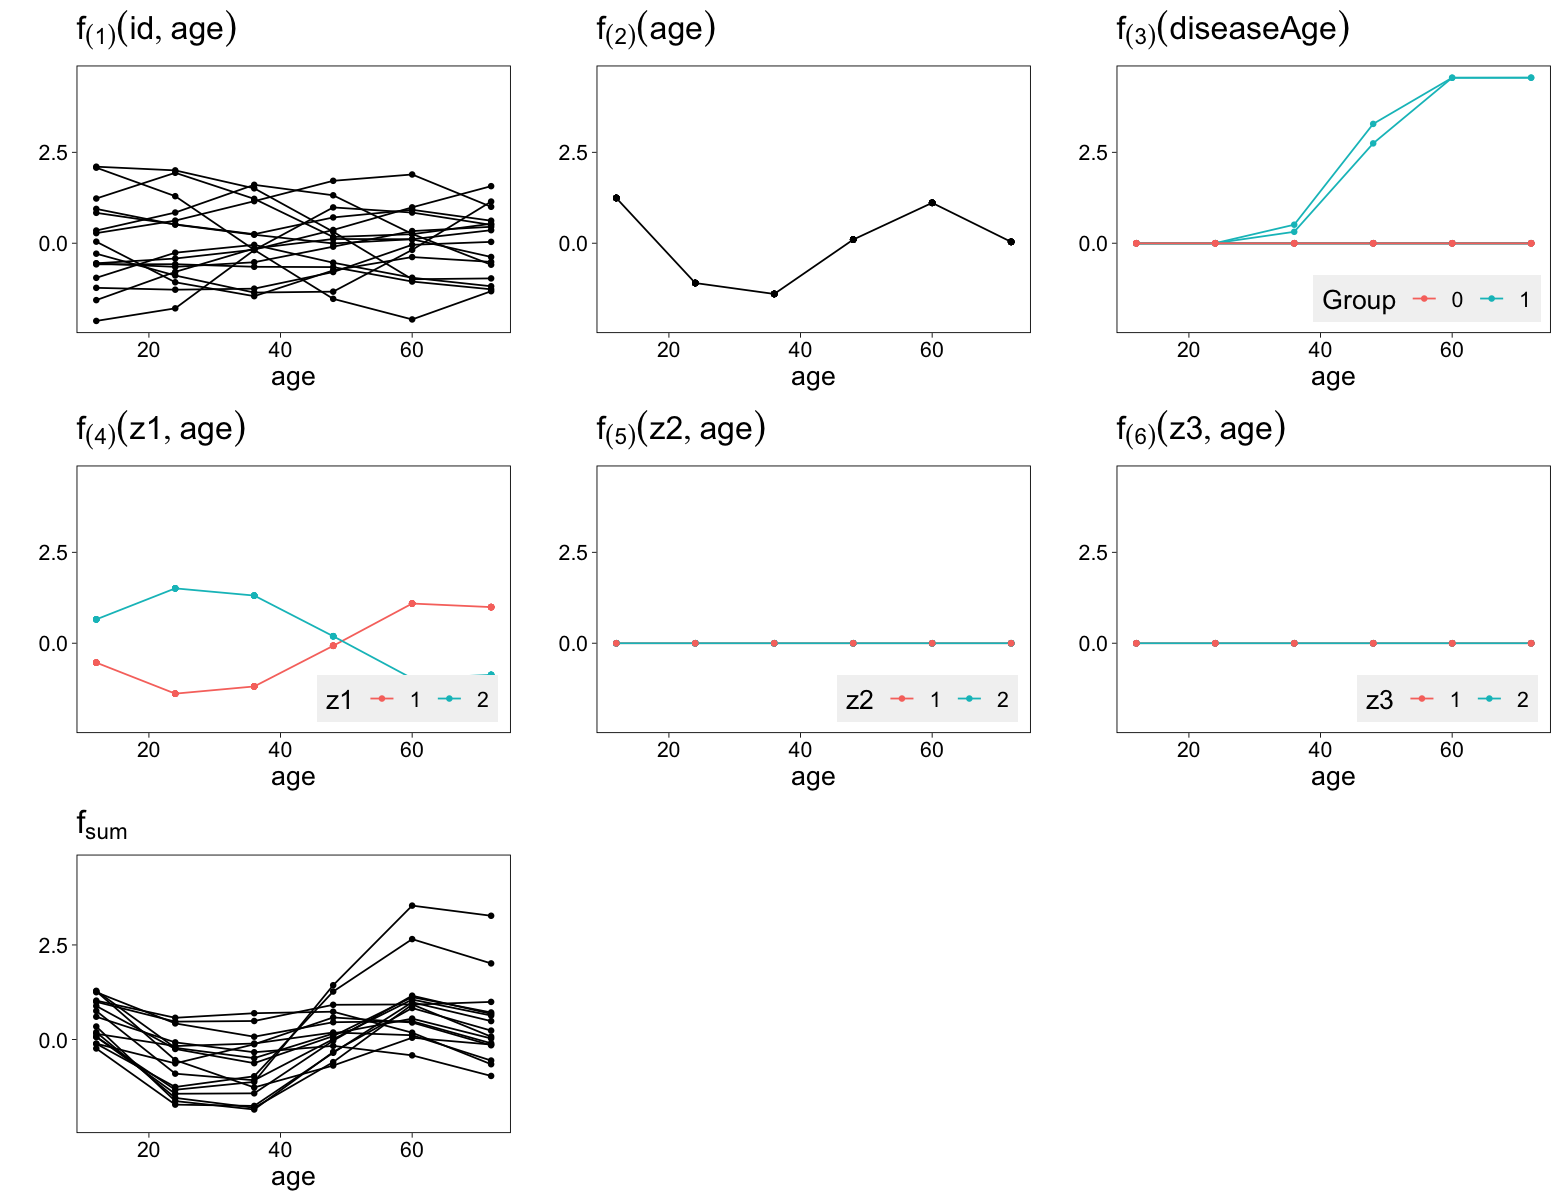

In [2]:
set.seed(121)
simData   <- simulate_data(N            = 16,
                           t_data       = seq(12, 72, by = 12),
                           covariates   = c(    0, 2,2,2),
                           relevances   = c(1,1,1, 1,0,0),
                           lengthscales = c(18,24, 1, 18,18,18),
                           t_effect_range  = c(46,48),
                           snr          = 5,
                           N_affected   = 2,
                           t_jitter     = 0)
  

FONT_SIZE <- 16
#options(repr.plot.width=14, repr.plot.height=5)
#plot_simdata(simData, nrow = 2, ncol = 6) + theme(text=element_text(size=FONT_SIZE)) 
options(repr.plot.width=13, repr.plot.height=10)
plot_components_simdata(simData, font_size = FONT_SIZE)
data <- simData$data

## 2. Fitting models
We fit two models. One where the effect is assumed equal for all individuals, and one where the effect magnitude can vary over individuals.

In [3]:
f1 <- lgp(formula        = y ~ id + age + diseaseAge + z1 + z2 + z3,
            data         = simData$data,
            equal_effect = FALSE,
            iter         = 2000,
            parallel     = TRUE)
  
  
f2 <- lgp(formula        = y ~ id + age + diseaseAge + z1 + z2 + z3,
            data         = simData$data,
            equal_effect = TRUE,
            iter         = 2000,
            parallel     = TRUE) 

In [4]:
print(f1)
print(f2)


 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 240.51 s (warmup) and 121.47 s (sampling)
* Largest R-hat value is 1.0054 (beta[1,2])
* Used relevance method = f_mean
* Used selection threshold = 0.95

                   Relevance Selected   Prob.
f[(1)](id, age)        0.221     TRUE 0.94425
f[(2)](age)            0.202     TRUE 1.00000
f[(3)](diseaseAge)     0.168     TRUE 0.78650
f[(4)](z1, age)        0.264     TRUE 0.99875
f[(5)](z2, age)        0.005    FALSE 0.00625
f[(6)](z3, age)        0.004    FALSE 0.00125
noise                  0.136     TRUE 1.00000


 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 91.31 s (warmup) and 75.42 s (sampling)
* Largest R-hat value is 1.0046 (lp__)
* Used relevance method = f_mean
* Used selection threshold = 0.95

                   Relevance Selected   Prob.
f[(1)](id, age)        0.357     TRUE 1.00000
f[(2)](age)            0.226     TRUE 1.00000
f[(3)](diseaseAge)     0.014    FALSE 0.08675
f[(4)](z

## 3. Visualization

In [15]:
# prediction 
t_test <- seq(0, 80, length.out=80)
X_test <- create_test_points(f1, t_test)
PRED1 <- lgp_predict(f1, X_test, samples = "map")
PRED2 <- lgp_predict(f2, X_test, samples = "map")

* Computing predictions using MAP parameters. 
* Computing predictions using MAP parameters. 


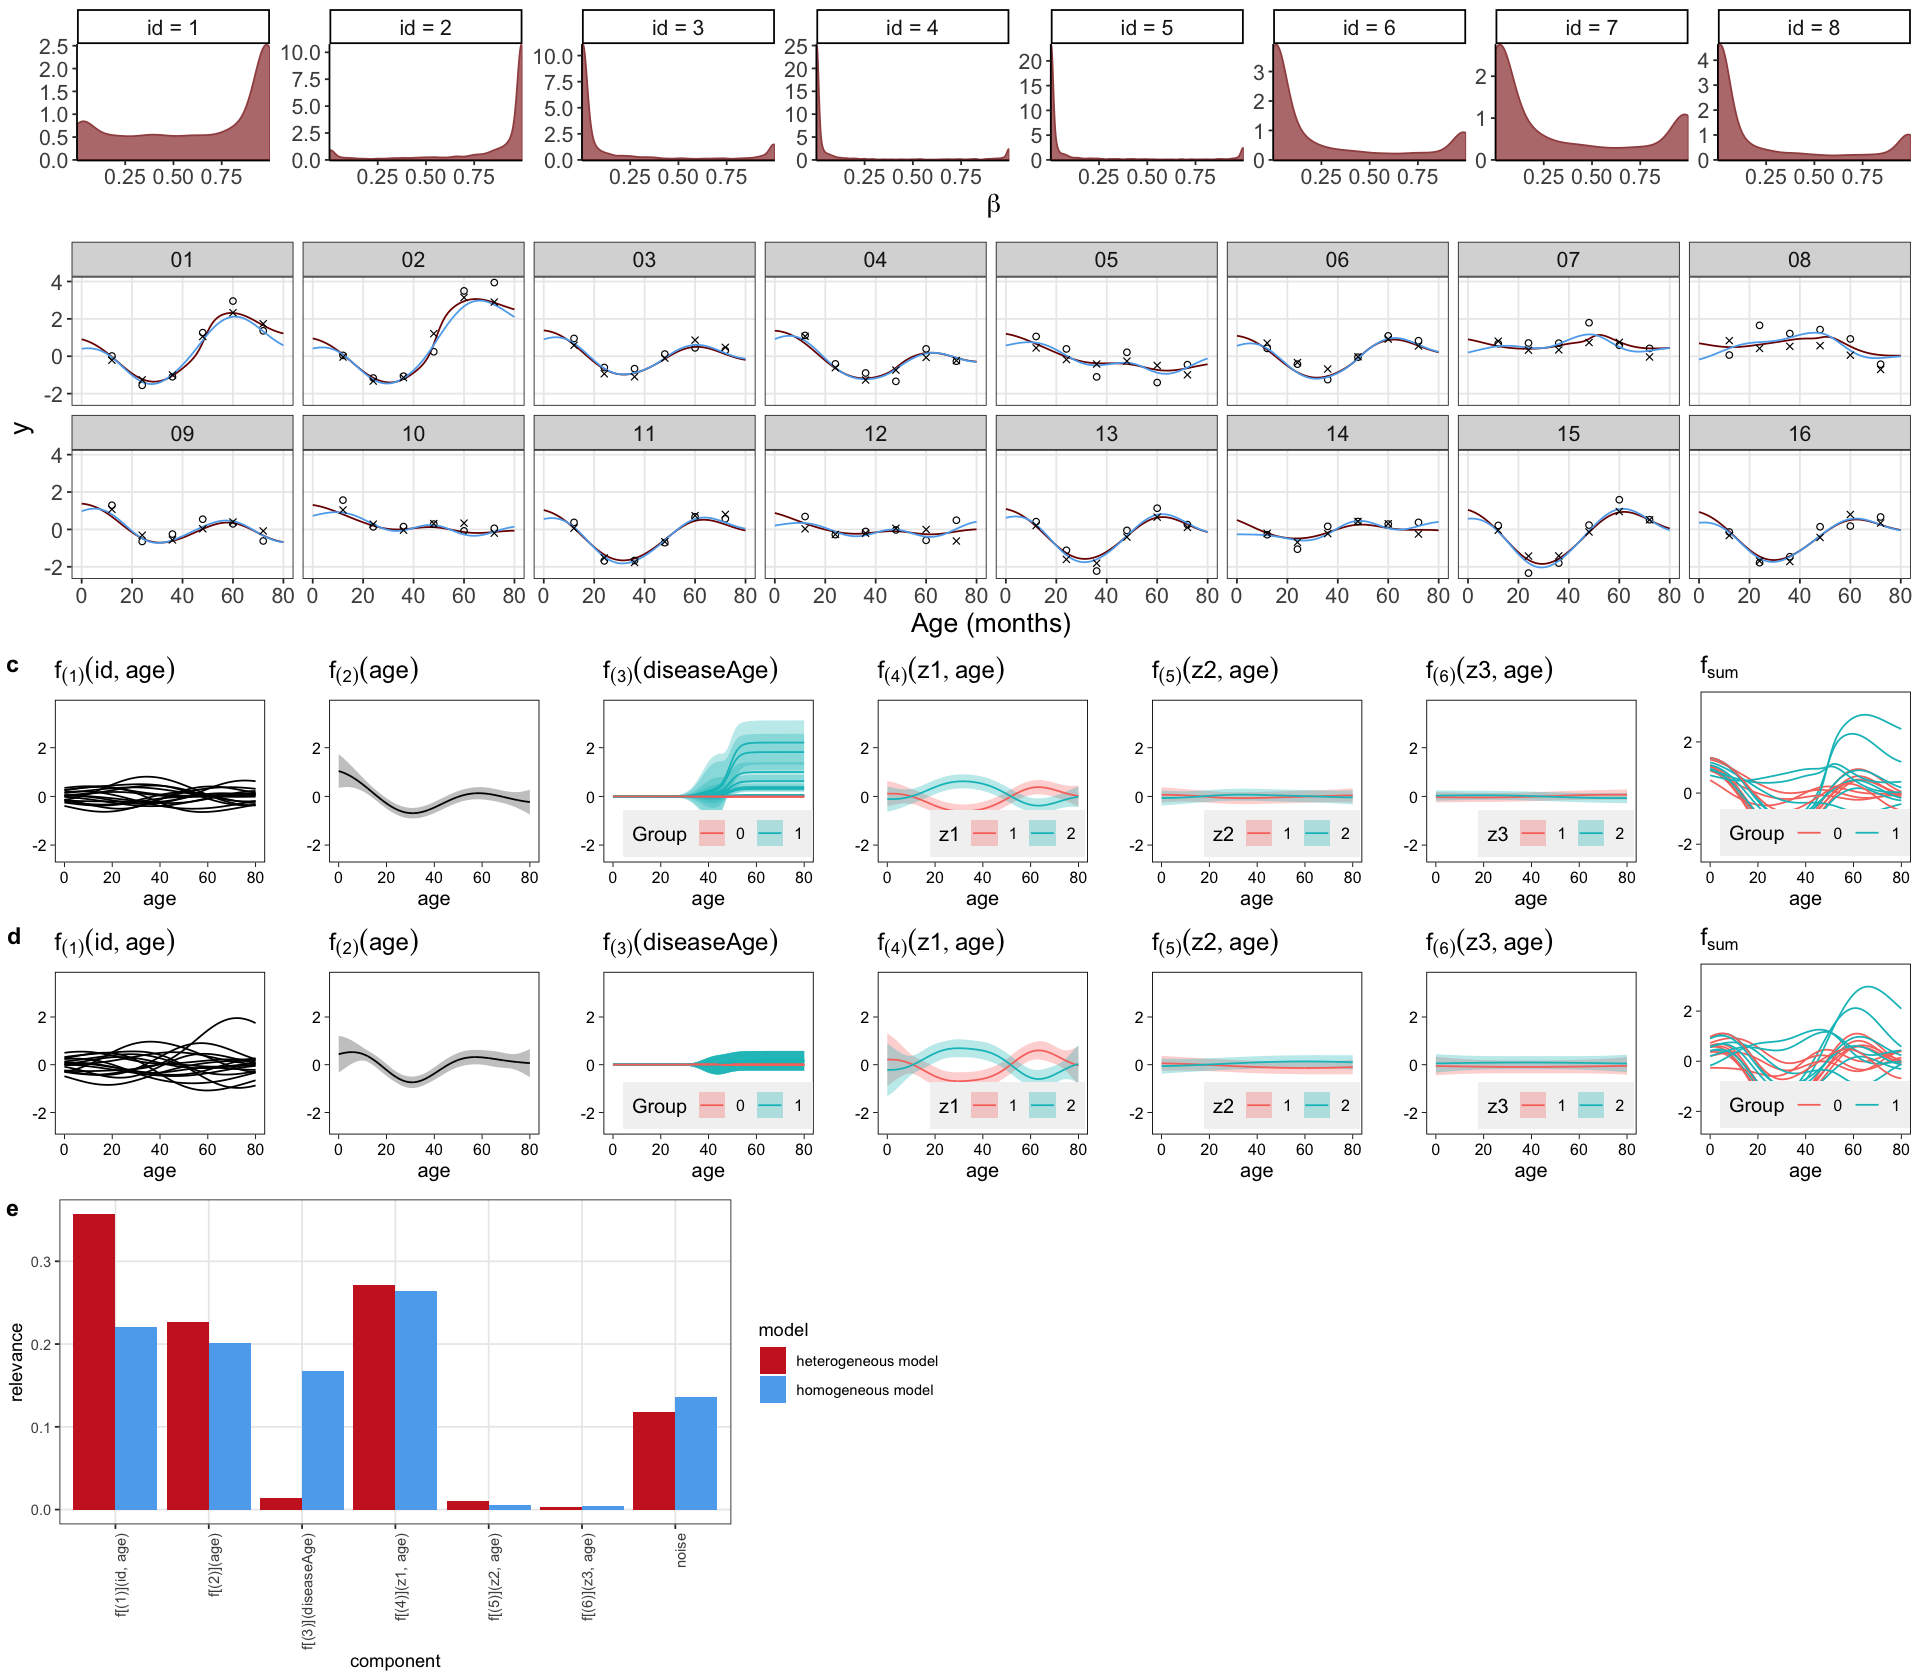

In [16]:
# plot
options(repr.plot.width=16, repr.plot.height=14)
p1 <- lgpr:::plot_posterior_predictions(f1, PRED = PRED1, mode = "predictive", 
                                        plot_uncertainty = FALSE,
                                        original_y_scale = FALSE) + theme_bw() +
  facet_wrap(~ facet_var, nrow = 2) +
  theme(panel.grid.minor = element_blank())

# Add other model's fit
id2    <- PRED2$X_test_scaled$id
fv     <- formatC(id2, flag = "0", width = 2)
age2   <- X_test[,2]
mu2    <- PRED2$LIST[[1]]$mu_f
df_add <- data.frame(fv, id2, age2, mu2)
colnames(df_add) <- c("facet_var", "id", "age", "mu_pred")
p1     <- p1 + geom_line(data = df_add, aes(x=age, y=mu_pred), lty=1, color = "steelblue2")
p1     <- p1 + xlab("Age (months)") + ylab("y") + theme(plot.title = element_blank())

# Add real generating process
f       <- simData$components$f
age     <- simData$data$age
id      <- simData$data$id
YSCL    <- f2@model@scalings$YSCL
f       <- YSCL$fun(f)
facet_var <- formatC(id, flag = "0", width = 2)
df_real <- data.frame(id, age, f, facet_var)
p1      <- p1 + geom_point(data = df_real, aes(x=age, y=f), pch = 4) + theme(text=element_text(size=FONT_SIZE)) 

p2 <- plot_components_posterior(f1, PRED=PRED1, font_size = 12, 
                                nrow = 1, ncol = 7, sum_highlight = "group")
p3 <- plot_components_posterior(f2, PRED=PRED2, font_size = 12, 
                                nrow = 1, ncol = 7, sum_highlight = "group")

p4 <- plot_beta(f1) + theme_classic() + theme(plot.title = element_blank(), plot.subtitle = element_blank())
p4 <- p4 + facet_wrap(. ~ Parameter, scales="free_y", nrow = 1, ncol = 8) +
      theme(text=element_text(size=FONT_SIZE)) + ylab(" ")

# Plot covariate relevances
r1a <- f1@relevances$average
r2a <- f2@relevances$average
m   <- as.factor(rep(c("homogeneous model", "heterogeneous model"), each = 7))
ha  <- c(r1a,r2a)
dfa <- data.frame(names(ha), ha, m)
colnames(dfa) <- c("component", "relevance", "model")

bar1 <- ggplot(dfa, aes(x = component, y = relevance, fill = model, group = model)) +
  geom_bar(stat = "identity", position = position_dodge()) + theme_bw() +
  theme(panel.grid.minor = element_blank()) + 
  scale_fill_manual(values=c('firebrick3','steelblue2')) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

bars <- ggarrange(bar1, ncol = 2, nrow = 1) + theme(text=element_text(size=FONT_SIZE)) 

# final plots
part1 <- p4
part2 <- p1
part3 <- ggarrange(p2, p3, bars, nrow = 3, ncol = 1, labels = c("c", "d", "e"), heights = c(1,1,1.8))

full <- ggarrange(part1, part2, part3, nrow = 3, ncol = 1, heights = c(0.9, 1.6, 4))
full

In [17]:
ggsave(file="demo_heterogeneous.pdf", plot=full, width=16, height=14)